In [1]:
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_score

In [144]:
mps=pd.read_csv(r"D:\data\mps.csv")

In [2]:
dt = pd.read_csv(r"C:\Users\Administrator\Desktop\fig3 Drug resistance\xgboost\DT.csv")
tn = pd.read_csv(r"C:\Users\Administrator\Desktop\fig3 Drug resistance\xgboost\TN.csv")

In [27]:
dt = pd.read_csv(r"D:\data\model\dt.csv")
tn = pd.read_csv(r"D:\data\model\tn.csv")

In [3]:

# 标记数据
dt['label'] = 1
tn['label'] = 0

# 合并数据
data = pd.concat([dt, tn], ignore_index=True)
# data=data.drop('Unnamed: 17',axis=1)
# 分离特征和标签
X = data.drop('label', axis=1)
y = data['label']

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [4]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [357]:
# 定义模型参数
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'max_depth':7,
    'eta': 0.2,
    'seed': 42
}

# 训练模型
num_rounds = 100
model = xgb.train(params, dtrain, num_rounds)

In [5]:
# test
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'max_depth':7,
    'eta': 0.15,
    'seed': 42,
    'alpha':2,
    'subsample':0.9,
    'gamma':0.01
    # 'colsample_bytree':0.5,
}

# 训练模型
num_rounds = 200
model = xgb.train(params, dtrain, num_rounds)

In [240]:
# 预测测试集
y_pred = model.predict(dtest)
y_pred = [round(value) for value in y_pred]

# 评估准确率
acc = accuracy_score(y_test, y_pred)
print('Accuracy:', acc)

Accuracy: 0.9487156538082878


d:\anaconda3\envs\sc\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
d:\anaconda3\envs\sc\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
d:\anaconda3\envs\sc\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
d:\anaconda3\envs\sc\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


d:\anaconda3\envs\sc\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
d:\anaconda3\envs\sc\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
d:\anaconda3\envs\sc\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
d:\anaconda3\envs\sc\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


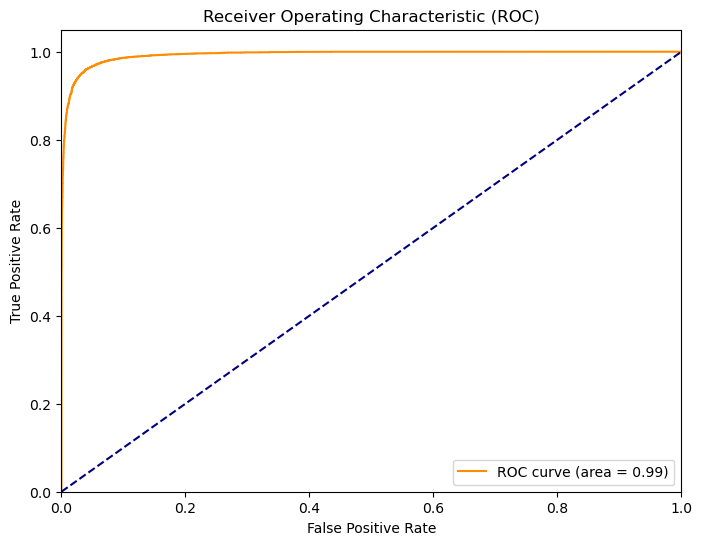

In [6]:
# 预测概率，并计算真正例率和假正例率
y_pred_proba = model.predict(dtest)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# 绘制ROC曲线
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [7]:
# 定义交叉验证
kf = KFold(n_splits=5, shuffle=True, random_state=42)
kf.get_n_splits(X)

# 开始交叉验证
auc_scores = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    model = xgb.train(params, dtrain, num_rounds)

    # 预测概率，并计算真正例率和假正例率
    y_pred_proba = model.predict(dtest)
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    auc_scores.append(roc_auc)

# 输出交叉验证结果
print('五折交叉验证AUC:', auc_scores)
print('平均AUC:', sum(auc_scores)/len(auc_scores))

d:\anaconda3\envs\sc\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
d:\anaconda3\envs\sc\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
d:\anaconda3\envs\sc\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
d:\anaconda3\envs\sc\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


五折交叉验证AUC: [0.9928296615158981, 0.9927879488006379, 0.992356087415955, 0.9931454705523153, 0.992435378745716]
平均AUC: 0.9927109094061045


d:\anaconda3\envs\sc\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
d:\anaconda3\envs\sc\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
d:\anaconda3\envs\sc\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
d:\anaconda3\envs\sc\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [8]:

# 开始交叉验证
accuracy_scores = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)


    model = xgb.train(params, dtrain, num_rounds)

    # 预测并计算准确率
    y_pred = model.predict(dtest) > 0.5
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)

# 输出交叉验证结果
print('五折交叉验证准确率:', accuracy_scores)
print('平均准确率:', sum(accuracy_scores)/len(accuracy_scores))

d:\anaconda3\envs\sc\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
d:\anaconda3\envs\sc\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
d:\anaconda3\envs\sc\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
d:\anaconda3\envs\sc\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


五折交叉验证准确率: [0.9610668576031505, 0.961693367940571, 0.9588740714221785, 0.9608878546496017, 0.9610651152383084]
平均准确率: 0.9607174533707621


d:\anaconda3\envs\sc\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
d:\anaconda3\envs\sc\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
d:\anaconda3\envs\sc\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
d:\anaconda3\envs\sc\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [9]:
model.save_model(r'D:\data\model/model_best2.bin')

d:\anaconda3\envs\sc\lib\site-packages\xgboost\core.py:160: UserWarning: [13:36:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


In [333]:
model = xgb.Booster(model_file=r'D:\data\model/model_best.bin')

In [250]:
new_datadt = pd.read_csv(r"F:\data\test\test_NSCLC.csv")
new_datatn= pd.read_csv(r"F:\data\test\test_NSCLC_0.csv")
testdata = pd.concat([new_datadt, new_datatn], ignore_index=True)

In [366]:
from sklearn.preprocessing import StandardScaler
new_data = pd.read_csv(r"F:\data\test\test_NSCLC_0.csv")
X_new = new_data.drop('label', axis=1)
y_prob = model.predict(xgb.DMatrix(X_new))
print('Predicted probabilities:', y_prob)
y_true= new_data['label']
y_pred_rounded = [round(value) for value in y_prob]
acc_new_data = accuracy_score(y_true, y_pred_rounded)
acc_new_data

Predicted probabilities: [0.66336936 0.5264809  0.70677394 ... 0.09102847 0.444445   0.8789955 ]


d:\anaconda3\envs\sc\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
d:\anaconda3\envs\sc\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
d:\anaconda3\envs\sc\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
d:\anaconda3\envs\sc\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


0.44849965640986483

In [364]:
X_new = testdata.drop('label', axis=1)
y_prob = model.predict(xgb.DMatrix(X_new))
print('Predicted probabilities:', y_prob)
y_true= testdata['label']
y_pred_rounded = [round(value) for value in y_prob]
acc_testdata = accuracy_score(y_true, y_pred_rounded)
acc_testdata

Predicted probabilities: [0.87698233 0.74715114 0.15215953 ... 0.09102847 0.444445   0.8789955 ]


d:\anaconda3\envs\sc\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
d:\anaconda3\envs\sc\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
d:\anaconda3\envs\sc\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
d:\anaconda3\envs\sc\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


0.49054594734124934

In [372]:
from sklearn.preprocessing import StandardScaler
new_data = pd.read_csv(r"F:\data\test\test_NSCLC.csv")
X_new = new_data.drop('label', axis=1)
y_prob = model.predict(xgb.DMatrix(X_new))
print('Predicted probabilities:', y_prob)
y_true= new_data['label']
y_pred_rounded = [round(value) for value in y_prob]
acc_new_data = accuracy_score(y_true, y_pred_rounded)
acc_new_data

Predicted probabilities: [0.87698233 0.74715114 0.15215953 ... 0.35342798 0.33332217 0.11987421]


d:\anaconda3\envs\sc\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
d:\anaconda3\envs\sc\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
d:\anaconda3\envs\sc\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
d:\anaconda3\envs\sc\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


0.7200917048770321

In [371]:
from sklearn.preprocessing import StandardScaler
new_data = pd.read_csv(r"D:\data\model\test1.csv")
X_new = new_data.drop('label', axis=1)
y_prob = model.predict(xgb.DMatrix(X_new))
print('Predicted probabilities:', y_prob)
y_true= new_data['label']
y_pred_rounded = [round(value) for value in y_prob]
acc_new_data = accuracy_score(y_true, y_pred_rounded)
acc_new_data


Predicted probabilities: [0.80125254 0.92795455 0.78349906 ... 0.26511863 0.84869754 0.80415976]


d:\anaconda3\envs\sc\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
d:\anaconda3\envs\sc\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
d:\anaconda3\envs\sc\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
d:\anaconda3\envs\sc\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


0.8039078855547802

In [267]:
new_data = pd.read_csv(r"F:\data\HNSCC_test.csv")
X_new = new_data.drop('Unnamed: 0', axis=1)
# X_new = new_data
y_prob = model.predict(xgb.DMatrix(X_new))
print('Predicted probabilities:', y_prob)

Predicted probabilities: [0.92518836 0.93449545 0.8121884  ... 0.5905403  0.8068933  0.7971487 ]


In [4]:
y_prob

array([0.96342146, 0.9479987 , 0.96285385, ..., 0.7436361 , 0.8861725 ,
       0.90855956], dtype=float32)

In [5]:
bar=pd.DataFrame(data=y_prob,index=new_data["Unnamed: 0"],columns=['data'])

In [6]:
df_sorted = bar.sort_values(by='data', ascending=False)

In [30]:
df_sorted.to_csv(r'D:\data\gli\sort_score.csv')

In [41]:
index_list = df_sorted[df_sorted['data'] > 0.8].index.tolist()

print(len(index_list))

6046


In [117]:
raw=pd.read_table(r"F:\data\GSE213047_HNSCC_scRNAseq_post_QC_count_matrix.txt\GSEXXXXX_HNSCC_post_QC_counts.txt")

In [118]:
raw=raw.set_index('gene')

In [119]:
raw=raw.T

In [83]:
result_df =raw[raw.index.isin(index_list)]

# 将筛选结果存储到 df1 中
adata = result_df.copy()

In [84]:
adata

gene                       AL627309.1  AP006222.2  RP11-206L10.3  \
HN19_1_AAACCTGCAATGAAAC-1           0           0              0   
HN19_1_AAACCTGTCCTGTAGA-1           0           0              0   
HN19_1_AAACGGGGTACCGCTG-1           0           0              0   
HN19_1_AAACGGGGTGCTTCTC-1           0           0              0   
HN19_1_AAACGGGGTGGGTCAA-1           0           0              0   
...                               ...         ...            ...   
HN19_3_TTTGTCAAGTCAAGCG-1           0           0              0   
HN19_3_TTTGTCACACCCTATC-1           0           0              0   
HN19_3_TTTGTCACAGTACACT-1           0           0              0   
HN19_3_TTTGTCAGTGTTAAGA-1           0           0              0   
HN19_3_TTTGTCATCGCACTCT-1           0           0              0   

gene                       RP11-206L10.2  RP11-206L10.9  LINC00115  FAM41C  \
HN19_1_AAACCTGCAATGAAAC-1              0              0          0       0   
HN19_1_AAACCTGTCCTGTAGA-1              0              0          0       0   
HN19_1_AAACGGGGTACCGCTG-1              0              0          0       0   
HN19_1_AAACGGGGTGCTTCTC-1              0              0          0       0   
HN19_1_AAACGGGGTGGGTCAA-1              0              0          0       0   
...                                  ...            ...        ...     ...   
HN19_3_TTTGTCAAGTCAAGCG-1              0              0          0       0   
HN19_3_TTTGTCACACCCTATC-1              0              0          0       0   
HN19_3_TTTGTCACAGTACACT-1              0              0          0       0   
HN19_3_TTTGTCAGTGTTAAGA-1              0              0          0       0   
HN19_3_TTTGTCATCGCACTCT-1              0              0          0       0   

gene                       RP11-54O7.3  SAMD11  NOC2L  ...  MT-ND6  MT-CYB  \
HN19_1_AAACCTGCAATGAAAC-1            0       0      0  ...       1      10   
HN19_1_AAACCTGTCCTGTAGA-1            0       0      0  ...       1      20   
HN19_1_AAACGGGGTACCGCTG-1            0       0      0  ...       1      15   
HN19_1_AAACGGGGTGCTTCTC-1            0       0      0  ...       0       4   
HN19_1_AAACGGGGTGGGTCAA-1            0       0      0  ...       2       7   
...                                ...     ...    ...  ...     ...     ...   
HN19_3_TTTGTCAAGTCAAGCG-1            0       0      0  ...       0       7   
HN19_3_TTTGTCACACCCTATC-1            0       0      1  ...       0      11   
HN19_3_TTTGTCACAGTACACT-1            0       0      0  ...       0       3   
HN19_3_TTTGTCAGTGTTAAGA-1            0       0      0  ...       2      21   
HN19_3_TTTGTCATCGCACTCT-1            0       0      0  ...       0       8   

gene                       AC145212.1  AC011043.1  AL592183.1  AC011841.1  \
HN19_1_AAACCTGCAATGAAAC-1           0           1           0           0   
HN19_1_AAACCTGTCCTGTAGA-1           0           0           0           0   
HN19_1_AAACGGGGTACCGCTG-1           0           0           0           0   
HN19_1_AAACGGGGTGCTTCTC-1           0           0           0           0   
HN19_1_AAACGGGGTGGGTCAA-1           0           0           0           0   
...                               ...         ...         ...         ...   
HN19_3_TTTGTCAAGTCAAGCG-1           0           0           0           0   
HN19_3_TTTGTCACACCCTATC-1           0           0           0           0   
HN19_3_TTTGTCACAGTACACT-1           0           0           0           0   
HN19_3_TTTGTCAGTGTTAAGA-1           0           0           0           0   
HN19_3_TTTGTCATCGCACTCT-1           0           0           0           0   

gene                       AL354822.1  KIR2DL2  PNRC2.1  SRSF10.1  
HN19_1_AAACCTGCAATGAAAC-1           0        0        0         0  
HN19_1_AAACCTGTCCTGTAGA-1           0        0        0         0  
HN19_1_AAACGGGGTACCGCTG-1           0        0        0         0  
HN19_1_AAACGGGGTGCTTCTC-1           0        0        0         0  
HN19_1_AAACGGGGTGGGTCAA-1           0       

In [32]:
df_sorted=df_sorted.T

In [26]:
import scanpy as sc
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import bbknn
import scanpy.external as sce
import seaborn as sns
from anndata import AnnData

d:\anaconda3\envs\sc\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
d:\anaconda3\envs\sc\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
d:\anaconda3\envs\sc\lib\site-packages\umap\distances.py:1086: NumbaDeprecationWarning: The 'nopython' keyword argument 

In [189]:
adata=sc.read_h5ad(r"F:\data\gli\新建文件夹\debatch.h5ad")

In [164]:
adata=sc.read_10x_mtx(path=r'F:\data\gli\GSE189650_RAW\GSM5705585_UW7_recurrent_biopsy_/', var_names='gene_symbols')

d:\anaconda3\envs\sc\lib\site-packages\anndata\_core\anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


In [221]:
adata=sc.read_text(r"D:\data\NSCLC\comb\GSM4869651_xCriz.dge.txt")
adata=adata.T

In [165]:
adata.var_names

Index(['MIR1302-2HG', 'FAM138A', 'OR4F5', 'AL627309.1', 'AL627309.3',
       'AL627309.2', 'AL627309.4', 'AL732372.1', 'OR4F29', 'AC114498.1',
       ...
       'AC007325.2', 'BX072566.1', 'AL354822.1', 'AC023491.2', 'AC004556.1',
       'AC233755.2', 'AC233755.1', 'AC240274.1', 'AC213203.1', 'FAM231C'],
      dtype='object', length=33538)

In [55]:
mpdrug=pd.read_csv(r"D:\data\model\MP_drug.csv")

In [57]:
data_list = mpdrug.values.flatten().tolist()

d:\anaconda3\envs\sc\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\anaconda3\envs\sc\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\anaconda3\envs\sc\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\anaconda3\envs\sc\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(v

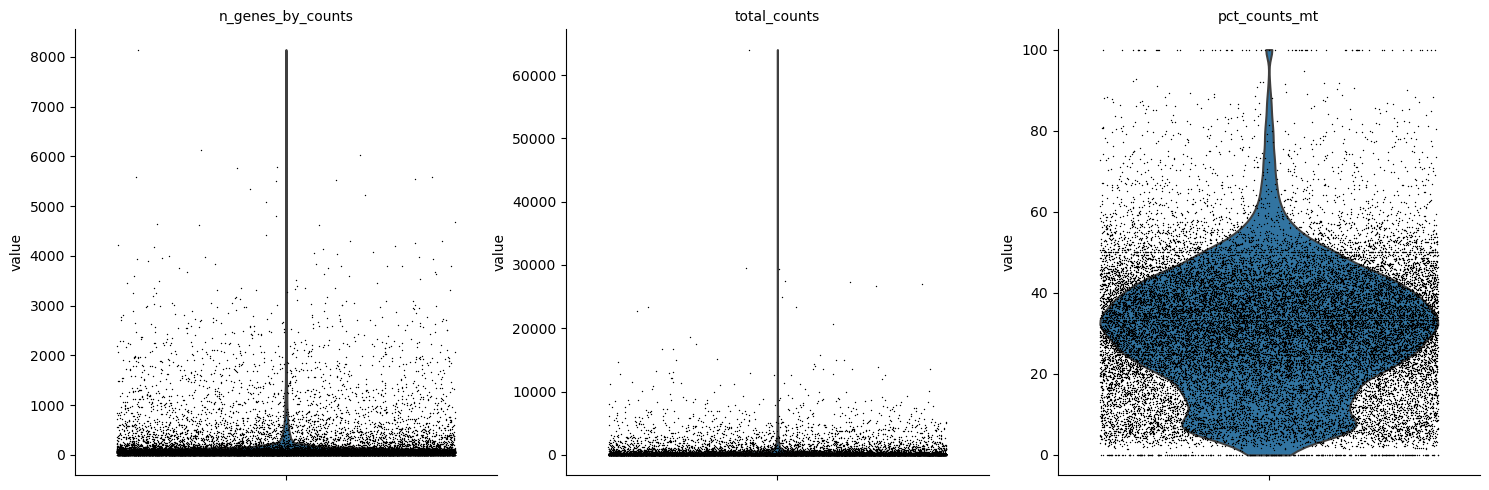

In [222]:
adata.var['mt'] = adata.var_names.str.startswith('MT')  # 将线粒体基因标记为 mt
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

In [223]:
adata = adata[adata.obs.pct_counts_mt < 60, :]

d:\anaconda3\envs\sc\lib\site-packages\anndata\_core\anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


In [208]:
adata = adata[adata.obs.n_genes_by_counts < 2500, :]

In [224]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata

d:\anaconda3\envs\sc\lib\site-packages\scanpy\preprocessing\_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [207]:
sc.pp.filter_cells(adata, min_genes=20)
sc.pp.filter_genes(adata, min_cells=3)


d:\anaconda3\envs\sc\lib\site-packages\scanpy\preprocessing\_simple.py:139: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
d:\anaconda3\envs\sc\lib\site-packages\anndata\_core\anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
d:\anaconda3\envs\sc\lib\site-packages\anndata\_core\anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


In [225]:
for col in mps.columns:
    col_list = mps[col].tolist()
    sc.tl.score_genes(adata,gene_list=col_list , score_name = col)

In [228]:
foo=adata.obs
foo

MP1  Cell Cycle - G2/M  MP2  Cell Cycle - G1/S  \
AAAAAACCACCT                0.037915               -0.050057   
AAAAACGTCTCT                0.186484                0.095445   
AAAAAGAGTAAG               -0.086591               -0.060689   
AAAAAGCAAAGG               -0.047765                0.087310   
AAAAAGGTCGAC                0.057161               -0.051999   
...                              ...                     ...   
TTTTTTGTTCCA               -0.063578               -0.016997   
TTTTTTTTACCG                0.227944                0.052375   
TTTTTTTTCCTC               -0.024368                0.080942   
TTTTTTTTGTCT               -0.068255               -0.038015   
TTTTTTTTTTTT                0.055738               -0.055586   

              MP3  Cell Cylce HMG-rich  MP4  Chromatin   MP5 Stress   \
AAAAAACCACCT                  0.206178         0.327706     0.498104   
AAAAACGTCTCT                  0.025752        -0.035035    -0.007473   
AAAAAGAGTAAG                  0.738763        -0.126817    -0.035461   
AAAAAGCAAAGG                  0.120793         0.063243    -0.020507   
AAAAAGGTCGAC                  0.081670        -0.049717    -0.039741   
...                                ...              ...          ...   
TTTTTTGTTCCA                 -0.055861         0.055968    -0.014558   
TTTTTTTTACCG                  0.411573        -0.059590     0.173417   
TTTTTTTTCCTC                  0.346732         0.064528     0.083279   
TTTTTTTTGTCT                 -0.046793         0.060248     0.077755   
TTTTTTTTTTTT                  0.491068         0.286125    -0.108726   

              MP6 Hypoxia  MP7 Stress (in vitro)  MP8 Proteasomal degradation  \
AAAAAACCACCT     0.103148               0.642839                     0.062000   
AAAAACGTCTCT     0.092459              -0.028566                    -0.062502   
AAAAAGAGTAAG     0.221915              -0.042956                     0.108609   
AAAAAGCAAAGG    -0.014683               0.150920                     0.171524   
AAAAAGGTCGAC    -0.020500              -0.042531                     0.035478   
...                   ...                    ...                          ...   
TTTTTTGTTCCA    -0.015635              -0.046376                    -0.040588   
TTTTTTTTACCG     0.036136              -0.093192                     0.148572   
TTTTTTTTCCTC    -0.022472              -0.035550                     0.000000   
TTTTTTTTGTCT    -0.013988              -0.016596                     0.072623   
TTTTTTTTTTTT     0.396263               0.110359                     0.282622   

              MP9 Unfolded protein response  MP10 Protein maturation  ...  \
AAAAAACCACCT                       0.243362                 0.242560  ...   
AAAAACGTCTCT                       0.086404                -0.058826  ...   
AAAAAGAGTAAG                       0.267108                 0.300158  ...   
AAAAAGCAAAGG                       0.189844                 0.007546  ...   
AAAAAGGTCGAC                       0.053859                -0.089057  ...   
...                                     ...                      ...  ...   
TTTTTTGTTCCA                      -0.045098                 0.036560  ...   
TTTTTTTTACCG                       0.138521                -0.067746  ...   
TTTTTTTTCCTC                      -0.032409                 0.018241  ...   
TTTTTTTTGTCT                       0.180854                 0.006154  ...   
TTTTTTTTTTTT                       0.527145                 0.458247  ...   

              MP32 Skin-pigmentation  MP33 RBCs  MP34 Platelet-activation  \
AAAAAACCACCT                0.019634   0.465421                  0.016535   
AAAAACGTCTCT               -0.005800  -0.016517                 -0.012284   
AAAAAGAGTAAG               -0.026721   0.219803                  0.225392   
AAAAAGCAAAGG               -0.010611  -0.046484                  0.130717   
AAAAAGGTCGAC               -0.009877   0.094961                 -0.031378   
...                 

In [227]:
foo=foo.drop(['n_genes_by_counts',	'total_counts',	'total_counts_mt',	'pct_counts_mt'],axis=1)
# foo=foo.drop(['n_genes_by_counts',	'total_counts'	,'total_counts_mt',	'pct_counts_mt'	,'n_genes'],axis=1)


In [229]:
tn = pd.read_csv(r"C:\Users\Administrator\Desktop\fig3 Drug resistance\xgboost\TN.csv")
common_columns = tn.columns.intersection(foo.columns)
# result_tn = tn[common_columns]
result_foo = foo[common_columns]

In [230]:
result_foo.to_csv(r'F:\data\test/test_NSCLC_0.csv')

In [216]:
# new_data = pd.read_csv(r"F:\data\HNSCC_test.csv")
# X_new = new_data.drop('Unnamed: 0', axis=1)
# X_new = new_data
y_prob = model.predict(xgb.DMatrix(result_foo))
print('Predicted probabilities:', y_prob)

Predicted probabilities: [0.69088197 0.7727364  0.20033915 ... 0.7179086  0.72651654 0.26874614]


In [199]:
bar=pd.DataFrame(data=y_prob,index=result_foo.index,columns=['data'])
df_sorted = bar.sort_values(by='data', ascending=False)
index_list = df_sorted[df_sorted['data'] > 0.8].index.tolist()
print(len(index_list))

21311


In [206]:
adata = adata[adata.obs.pct_counts_mt <20, :]

d:\anaconda3\envs\sc\lib\site-packages\anndata\_core\anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


d:\anaconda3\envs\sc\lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:215: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']


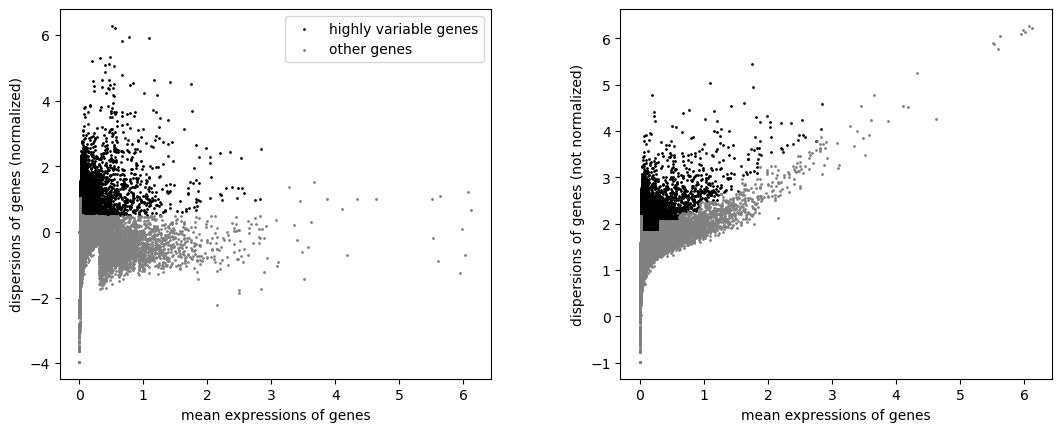

In [175]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
# 绘制特异性基因散点图
sc.pl.highly_variable_genes(adata)

d:\anaconda3\envs\sc\lib\site-packages\anndata\_core\anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
d:\anaconda3\envs\sc\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


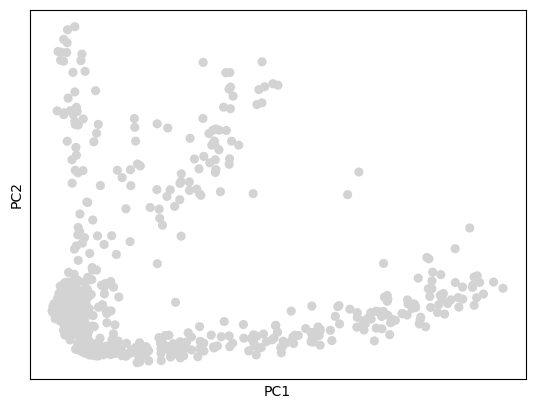

In [176]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca(adata)

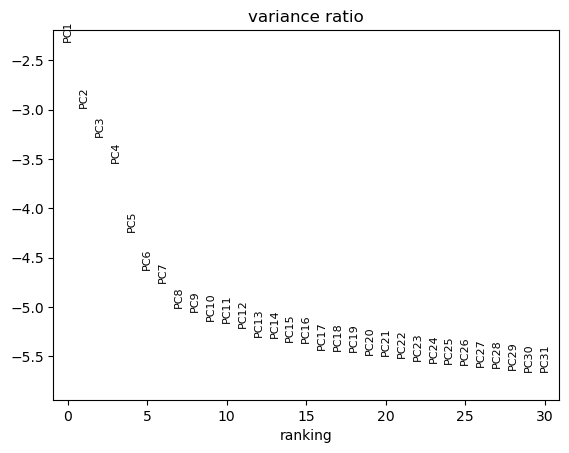

In [177]:
sc.pl.pca_variance_ratio(adata, log=True)

d:\anaconda3\envs\sc\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


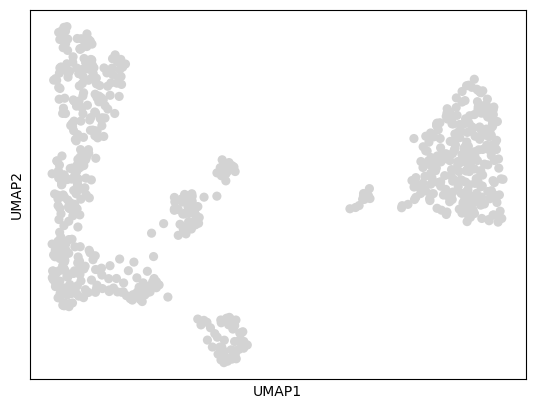

In [182]:
sc.pp.neighbors(adata, n_neighbors=50, n_pcs=20)
sc.tl.umap(adata)
sc.pl.umap(adata, )


d:\anaconda3\envs\sc\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
d:\anaconda3\envs\sc\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
d:\anaconda3\envs\sc\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


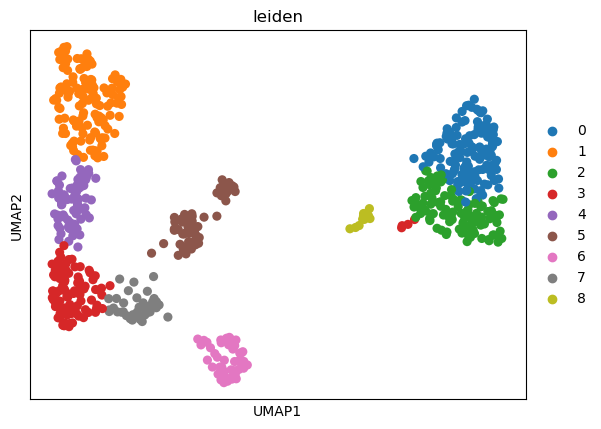

In [183]:
sc.tl.leiden(adata)
# 绘制
sc.pl.umap(adata, color=['leiden'])

In [186]:
foo=list(set(data_list)&set(adata.var_names))

In [103]:
bar=adata.to_df()
bar=bar.T

In [104]:
result_df = bar[bar.index.isin(foo)]

# 将筛选结果存储到 df1 中
bar = result_df.copy()

d:\anaconda3\envs\sc\lib\site-packages\scanpy\plotting\_anndata.py:1067: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if isinstance(groupby, str) and is_categorical_dtype(adata.obs[groupby]):


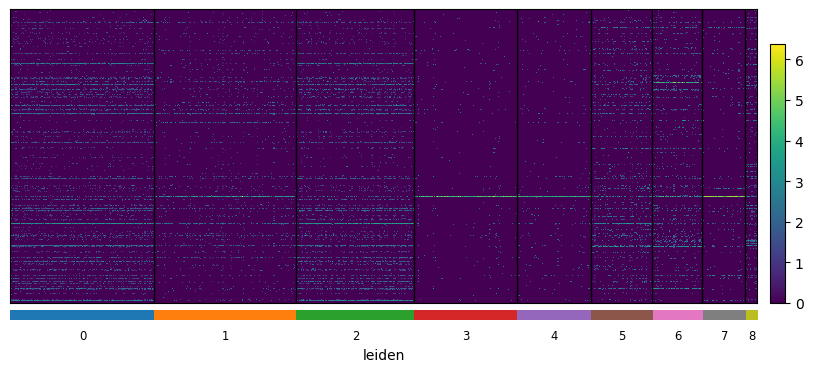

In [187]:
sc.pl.heatmap(adata, foo, groupby='leiden', swap_axes=True)

In [200]:
adata.obs['batch'] = 'low'
adata.obs.loc[adata.obs.index.isin(index_list), 'batch'] = 'high'

d:\anaconda3\envs\sc\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
d:\anaconda3\envs\sc\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
d:\anaconda3\envs\sc\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
d:\anaconda3\envs\sc\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future versio

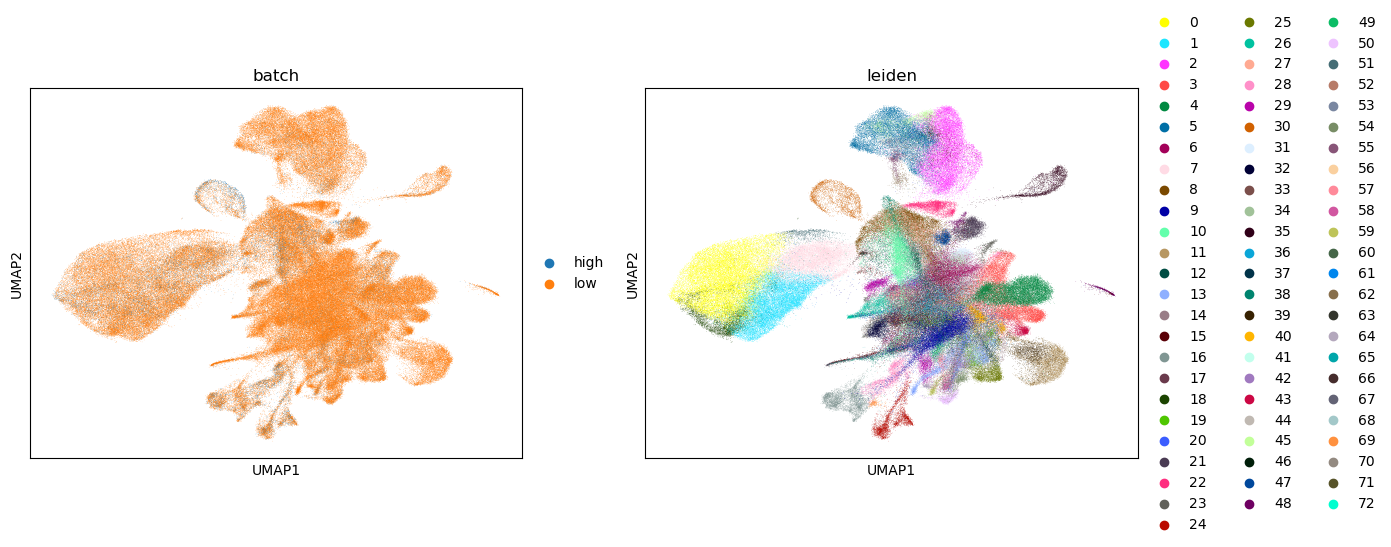

In [201]:
sc.pl.umap(adata, color=['batch','leiden'])